# Is making song an art or science?

In [101]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [102]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [149]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [150]:
df = pd.read_csv('dataset-of-00s.csv')

In [151]:
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1


Number of Rows

In [152]:
len(df)

5872

Base Rate

In [153]:
df['target'].mean()

0.5

In [154]:
#drop useless column
df = df.drop('uri', axis=1)

In [155]:
#create a copy of df 
df_copy = df.copy()

In [156]:
#one hot encode categorical columns
categorical_columns = ['key', 'time_signature']
for col in categorical_columns:
  encoded = pd.get_dummies(df_copy [col],prefix = str(col), drop_first=True)
  df_copy = df_copy.join(encoded)
  df_copy = df_copy.drop(col, axis=1)
df_copy = df_copy[[c for c in df_copy if c not in ['target']] 
       + ['target']]
df_copy.head(5)

,track,artist,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,chorus_hit,sections,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5,target
0,Lucky Man,Montgomery Gentry,0.578,0.471,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,30.88059,13,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
1,On The Hotline,Pretty Ricky,0.704,0.854,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,41.51106,10,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
2,Clouds Of Dementia,Candlemass,0.162,0.836,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,65.32887,13,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,"Heavy Metal, Raise Hell!",Zwartketterij,0.188,0.994,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,58.59528,9,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,I Got A Feelin',Billy Currington,0.630,0.764,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,22.62384,10,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [157]:
#more columns were added
df_copy.shape

(5872, 31)

In [159]:
#check na
df.isna().apply(sum, axis = 0)

track               0
artist              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64

### VIF: To check interdependence of X variables

In [206]:
## Checking the VIFs to assess dependence of all X variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df_int = df_copy[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','chorus_hit']]
## Creating and storing in a dataframe
vif_df = pd.DataFrame({ 'columns': vif_df_int.columns,
                          'VIF': [variance_inflation_factor(vif_df_int.to_numpy() , i) for i in range(len(vif_df_int.columns))]
                      })
vif_df.sort_values('VIF' , ascending= False).head(10)

,columns,VIF
1,energy,18.171984
8,tempo,15.429150
0,danceability,11.991244
7,valence,8.118385
2,loudness,6.990058
10,chorus_hit,4.947503
9,duration_ms,4.539776
4,acousticness,3.377998
6,liveness,2.675209
3,speechiness,2.102725


In [207]:
correlated_features = vif_df.loc[vif_df['VIF']>4, 'columns'].tolist()
correlated_features

['danceability',
 'energy',
 'loudness',
 'valence',
 'tempo',
 'duration_ms',
 'chorus_hit']

may drop these highly correlated columns

In [ ]:
##drop_cols = ['energy', 'danceability]
##model_df_cols_dropped = df_copy.drop(drop_cols, axis = 1)

In [158]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

## EDA

### Is there relation between the notes you use the most in your song and probability of song's success?

<AxesSubplot:xlabel='key', ylabel='count'>

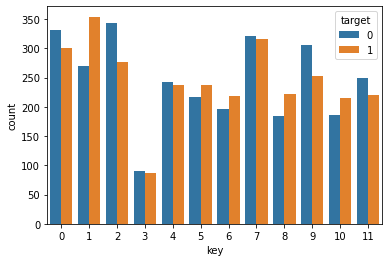

In [51]:
sns.countplot(data = df, x = "key", hue = "target")

No

### Is there a "holy grail" song duration that increases chances of success?

(0.0, 14.0)

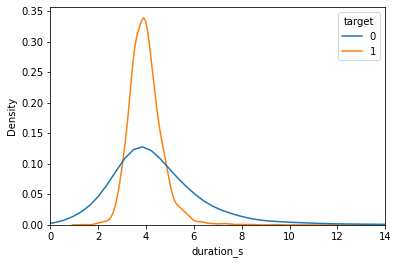

In [52]:
df['duration_s'] = df['duration_ms']/60000
sns.kdeplot(data = df, x = "duration_s", hue = "target")
plt.xlim(0,14)

Yes.
Anything out of the range of (2, 6) min has a low chance of success

### Do dance numbers have higher chances of being hit?

<AxesSubplot:xlabel='target', ylabel='danceability'>

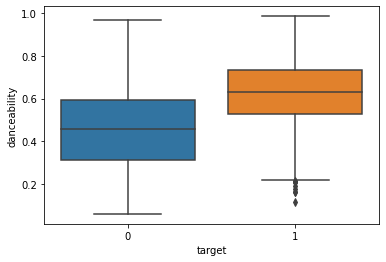

In [53]:
sns.boxplot(data = df, y = "danceability", x = "target")

<AxesSubplot:xlabel='danceability', ylabel='Density'>

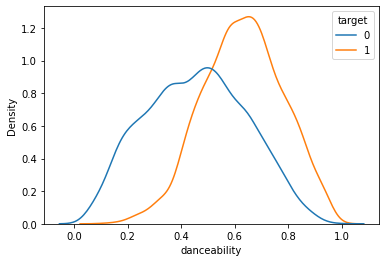

In [54]:
sns.kdeplot(data = df, x = "danceability", hue = "target")

Definitely, there some relation between dancability and song's chances of being a hit

### Do loud and high energy songs have a higher chance of being a hit?

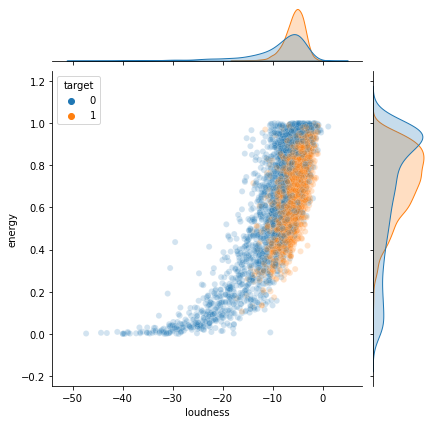

In [55]:
sns.jointplot(data = df, x = 'loudness', y = 'energy', hue='target', alpha= 0.2)

Some combinations definitely have higher chances of being a hit than others

### When should you put in your chorus to garauntee success?

<AxesSubplot:xlabel='chorus_perc', ylabel='Density'>

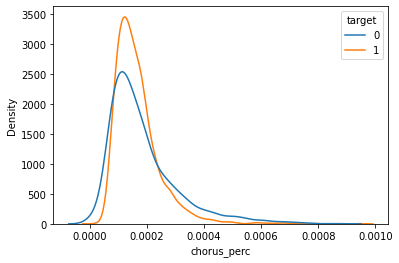

In [56]:
df['chorus_perc'] = df['chorus_hit'] / df['duration_ms'] 
sns.kdeplot(data = df, x = 'chorus_perc', hue = 'target')

No clear differentiation. Singer seem to be adding their chorus at the same time

### Are hit singers born or made?

In [174]:
artist_hit_stat = df.groupby('artist')['target'].agg(['mean', 'count'])
artist_hit_stat = artist_hit_stat[artist_hit_stat['count'] > 2]

<AxesSubplot:xlabel='mean', ylabel='Count'>

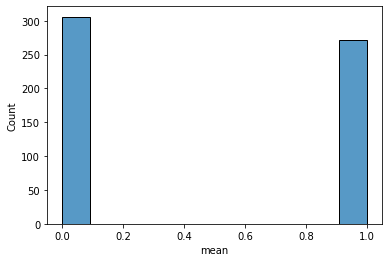

In [175]:
sns.histplot(artist_hit_stat, x = 'mean')

So acc. to this data, if your first song was not a hit then there are zero chances of song being a hit.

### top 10 artist from 2000-2010

In [172]:
artist = df[['artist', 'target']]
artist.groupby('artist').sum().sort_values('target', ascending = False)[:10]

,target
artist,
Toby Keith,27
Rascal Flatts,24
Tim McGraw,24
Kenny Chesney,23
George Strait,22
Brad Paisley,20
Keith Urban,20
Britney Spears,19
Alan Jackson,19


### Acousticness

<AxesSubplot:xlabel='acousticness', ylabel='Density'>

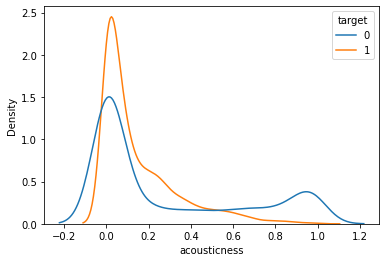

In [161]:
sns.kdeplot(data = df, x = "acousticness", hue = "target")

### Instrumentalness

<AxesSubplot:xlabel='instrumentalness', ylabel='Density'>

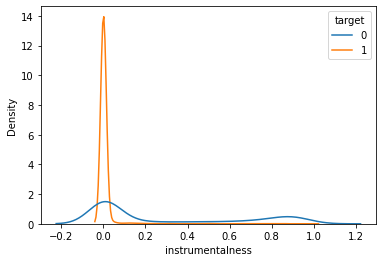

In [162]:
 sns.kdeplot(data = df, x = "instrumentalness", hue = "target")

All hits seem to be vocal

### Energy

<AxesSubplot:xlabel='energy', ylabel='Density'>

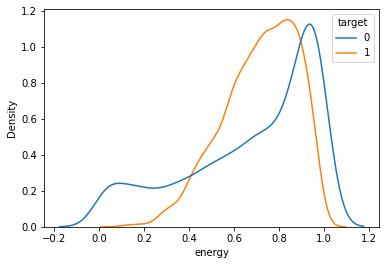

In [176]:
 sns.kdeplot(data = df, x = "energy", hue = "target")

### Valence

<AxesSubplot:xlabel='valence', ylabel='Density'>

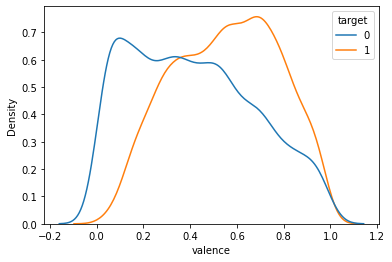

In [180]:
 sns.kdeplot(data = df, x = "valence", hue = "target")

More positive (happy, cheerful) songs are tend to be hits

### Sections

<AxesSubplot:xlabel='sections', ylabel='Density'>

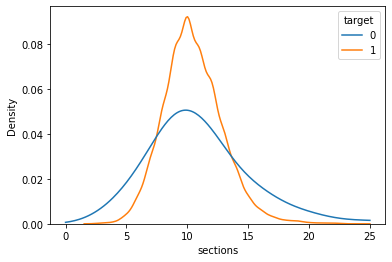

In [190]:
 sns.kdeplot(data = df, x = "sections", hue = "target", clip=(0, 25))

<AxesSubplot:xlabel='sections', ylabel='Density'>

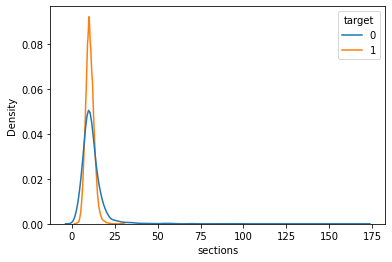

In [191]:
 sns.kdeplot(data = df, x = "sections", hue = "target")

long tail for non-hits

### Mode

<AxesSubplot:xlabel='mode', ylabel='count'>

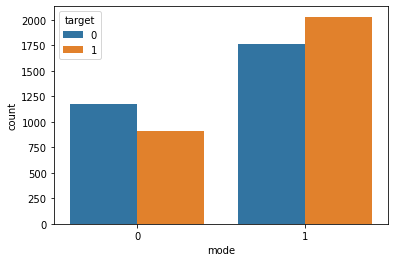

In [185]:
sns.countplot(data = df, x = "mode", hue = "target")

## Modelling

In [59]:
# startifying based on target so that class represntation is same in train and test 
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.9,
                                                    stratify = y)

In [60]:
# startifying based on target so that class represntation is same in train and test 
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                    train_size=0.8,
                                                    stratify = train_y)

In [61]:
scaler = StandardScaler()

train_X = scaler.fit_transform(train_X.iloc[:, 2:])
val_X = scaler.fit_transform(val_X.iloc[:, 2:])

test_X = scaler.fit_transform(test_X.iloc[:, 2:])

We will skip character columns for first model

In [62]:
lr = LogisticRegression(C = 1)

In [63]:
lr.fit(train_X, train_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

<AxesSubplot:>

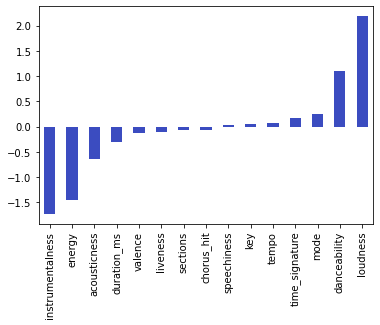

In [64]:
pd.Series(index = X.columns.values[2:], 
          data = lr.coef_.tolist()[0]).\
                    sort_values().\
                    plot(kind = 'bar', cmap = "coolwarm")

In [65]:
lr.score(train_X, train_y)

0.8204400283889283

In [66]:
lr.score(val_X, val_y)

0.8306527909176916

In [67]:
predictions = lr.predict(val_X)

confusion_matrix(val_y, predictions)

array([[405, 124],
       [ 55, 473]])

In [68]:
rf = RandomForestClassifier(ccp_alpha = .001)

TypeError: __init__() got an unexpected keyword argument 'ccp_alpha'

In [69]:
rf.fit(train_X, train_y)

NameError: name 'rf' is not defined

In [70]:
rf.feature_importances_

NameError: name 'rf' is not defined

In [71]:
pd.Series(index = X.columns.values[2:], 
          data = rf.feature_importances_.tolist()).\
                    sort_values().\
                    plot(kind = 'bar')

NameError: name 'rf' is not defined

In [72]:
rf.score(train_X, train_y)

NameError: name 'rf' is not defined

In [73]:
rf.score(val_X, val_y)

NameError: name 'rf' is not defined

In [74]:
predictions = rf.predict(val_X)

confusion_matrix(val_y, predictions)

NameError: name 'rf' is not defined

In [75]:
xgb = XGBClassifier(eta = 0.4)

In [76]:
xgb.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.4, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [77]:
xgb.score(train_X, train_y)

0.8847882659096286

In [78]:
xgb.score(val_X, val_y)

0.8448438978240302

In [79]:
predictions = xgb.predict(val_X)

confusion_matrix(val_y, predictions)

array([[437,  92],
       [ 72, 456]])

In [80]:
lr.score(test_X, test_y)

0.8163265306122449

In [81]:
rf.score(test_X, test_y)

NameError: name 'rf' is not defined

In [82]:
xgb.score(test_X, test_y)

0.8197278911564626